In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf

## import data

In [2]:
SSH_train = np.expand_dims(np.load('../Data/adt_train.npy'),3)[:,:-1,1:,:]
SSH_test = np.expand_dims(np.load('../Data/adt_test.npy'),3)[:,:-1,1:,:]

SSH_train[np.isnan(SSH_train)] = -1
SSH_test[np.isnan(SSH_test)] = -1

SSH_train=tf.pad(SSH_train, [[0,0],[0,0],[6,6],[0,0]], 'CONSTANT', constant_values=-1)
SSH_test=tf.pad(SSH_test, [[0,0],[0,0],[6,6],[0,0]], 'CONSTANT', constant_values=-1)
#######
Seg_train = np.expand_dims(np.load('../Data/grid_all_train_simple.npy'),3)[:,:-1,1:,:]
Seg_test = np.expand_dims(np.load('../Data/grid_all_test_simple.npy'),3)[:,:-1,1:,:]

Seg_train=tf.pad(Seg_train, [[0,0],[0,0],[6,6],[0,0]], 'CONSTANT', constant_values=0)
Seg_test=tf.pad(Seg_test, [[0,0],[0,0],[6,6],[0,0]], 'CONSTANT', constant_values=0)
######
SSH_train=tf.cast(SSH_train,dtype=tf.float32)
SSH_test=tf.cast(SSH_test,dtype=tf.float32)
######
Seg_train=tf.cast(Seg_train,dtype=tf.int8)
Seg_test=tf.cast(Seg_test,dtype=tf.int8)
######
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

2024-05-15 18:54:27.419714: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-15 18:54:27.419766: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-15 18:54:27.419774: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-15 18:54:27.419871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-15 18:54:27.420060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([7305, 80, 192, 1])

TensorShape([365, 80, 192, 1])

TensorShape([7305, 80, 192, 1])

TensorShape([365, 80, 192, 1])

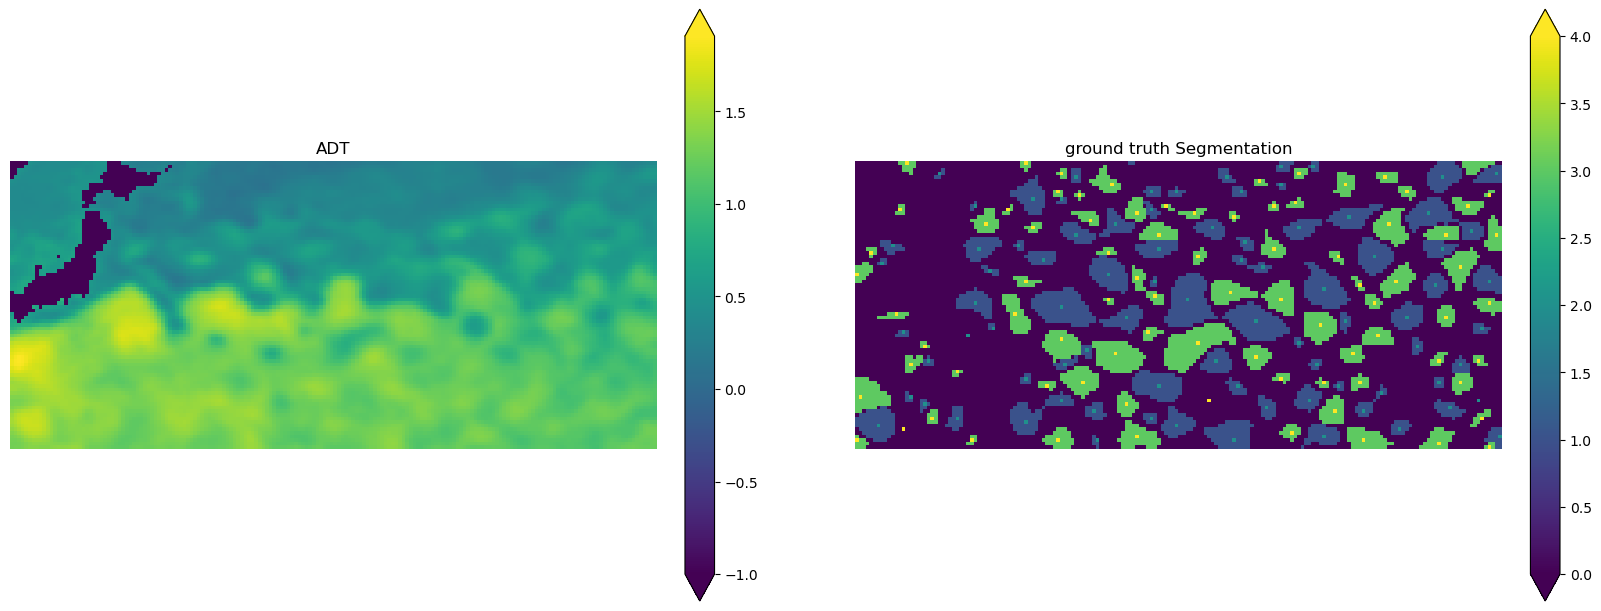

In [3]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,::-1,6:-6,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ADT');

plt.subplot(122)
plt.imshow(Seg_train[randindex,::-1,6:-6,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Eddynet 

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
import keras.utils as utils     #更改代码
from keras.optimizers import legacy     #更改代码
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils import model_to_dot    #更改代码
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf

In [5]:
Seg_train_categor = utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(7305,80*192)),5)    #更改代码
Seg_train_categor.shape

(7305, 15360, 5)

In [6]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [7]:
width = 192
height = 80
nbClass = 5
nf = 32
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = ConvBNActi(nf,ker,pool3)
conv4 = ConvBNActi(nf,ker,conv4)
conv4 = Dropout(0.4)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#######################################center

convC = ConvBNActi(nf,ker,pool4)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up4 = concatenate([ConvTranspBNActi(nf,ker,convC), conv4])
up4 = concatenate([UpSampling2D((2,2))(convC), conv4])
decod4 = ConvBNActi(nf,ker,up4)
decod4 = ConvBNActi(nf,ker,decod4)
decod4 = Dropout(0.4)(decod4)

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(decod4), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.3)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.2)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.1)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 192, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 192, 16)          144       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 192, 16)          64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 192, 16)          0         ['batch_normalization[0][0

### calculate weights (some heavy data imbalance out there...)

In [8]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0: 80333001, 1: 15949436, 2: 617968, 3: 14659826, 4: 644569}

In [9]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.0037573854650822026,
 0.01892493567320086,
 0.48844284869739857,
 0.020589743038139336,
 0.4682850871261789]

## loss functions

In [10]:
smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_anti_core(y_true, y_pred):
    y_true_anti = y_true[:,:,2]
    y_pred_anti = y_pred[:,:,2]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,3]
    y_pred_cyc = y_pred[:,:,3]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_cyc_core(y_true, y_pred):
    y_true_cyc = y_true[:,:,4]
    y_pred_cyc = y_pred[:,:,4]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_anti_core(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_cyc_core(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/5.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.2*dice_coef_anti(y_true, y_pred) + 0.19*dice_coef_cyc(y_true, y_pred) + 0.01*dice_coef_nn(y_true, y_pred) + 0.3*dice_coef_anti_core(y_true, y_pred) + 0.3*dice_coef_cyc_core(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [11]:
eddynet.compile(optimizer=legacy.Adam(learning_rate=1e-3), loss=dice_coef_loss,    #更改代码
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

In [12]:
#SVG(model_to_dot(eddynet).create(prog='dot', format='svg'))

## Training

In [13]:
earl = EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=50, verbose=1, mode='auto')
modelcheck = ModelCheckpoint('./weights/eddynetfirst.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=500,
                              batch_size=64,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall,earl],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )

Epoch 1/500


2024-05-15 18:54:36.995781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.8290 - categorical_accuracy: 0.3245 - mean_dice_coef: 0.2321 - weighted_mean_dice_coef: 0.1713
Epoch 1: val_loss improved from inf to 0.81105, saving model to ./weights/eddynetfirst.h5
92/92 [==============================] - 22s 209ms/step - loss: 0.8290 - categorical_accuracy: 0.3245 - mean_dice_coef: 0.2321 - weighted_mean_dice_coef: 0.1713 - val_loss: 0.8111 - val_categorical_accuracy: 0.3871 - val_mean_dice_coef: 0.2417 - val_weighted_mean_dice_coef: 0.1889 - lr: 0.0010
Epoch 2/500
92/92 [==============================] - ETA: 0s - loss: 0.7667 - categorical_accuracy: 0.5235 - mean_dice_coef: 0.3371 - weighted_mean_dice_coef: 0.2334
Epoch 2: val_loss improved from 0.81105 to 0.76650, saving model to ./weights/eddynetfirst.h5
92/92 [==============================] - 16s 171ms/step - loss: 0.7667 - categorical_accuracy: 0.5235 - mean_dice_coef: 0.3371 - weighted_mean_dice_coef: 0.2334 - val_loss: 0.7665 - val_categorical_acc

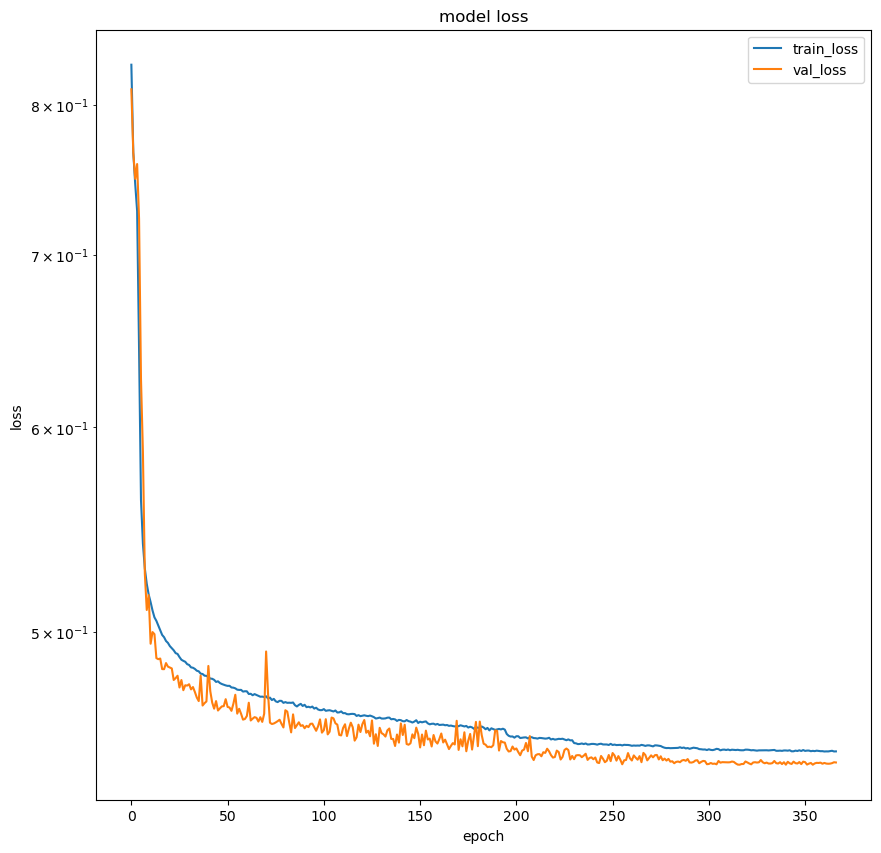

In [14]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

## Performance on train dataset 
just to be sure...

1/1 [==============================] - 1s 568ms/step


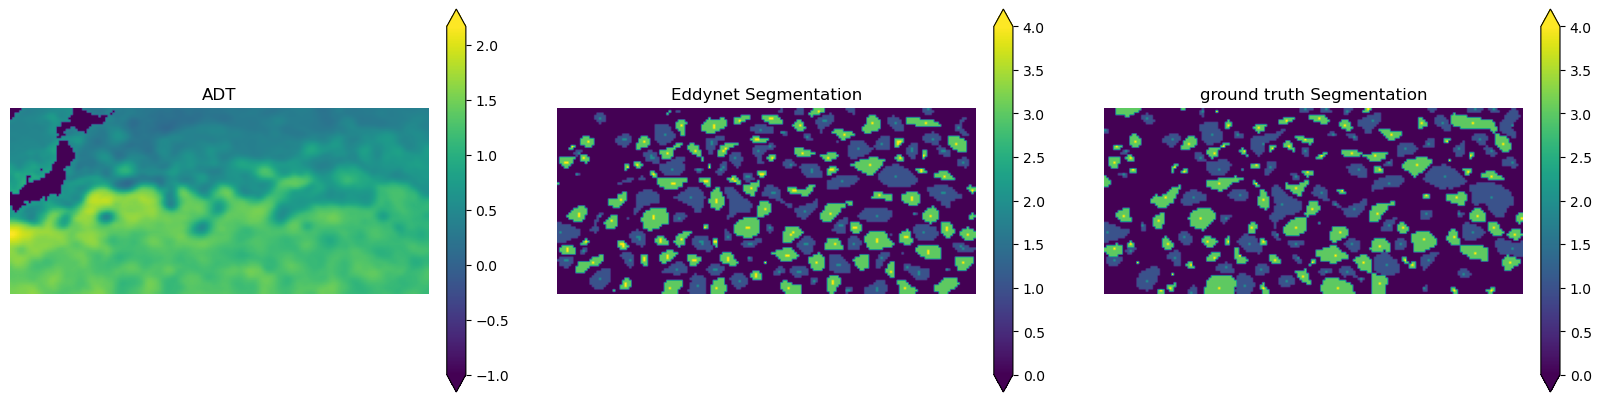

In [15]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))
predictedSEGMimage=predictedSEGMimage[::-1,6:-6]

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(SSH_train[randindex,::-1,6:-6,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ADT');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,::-1,6:-6,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Performance on test dataset (2019 data)

1/1 [==============================] - 0s 20ms/step


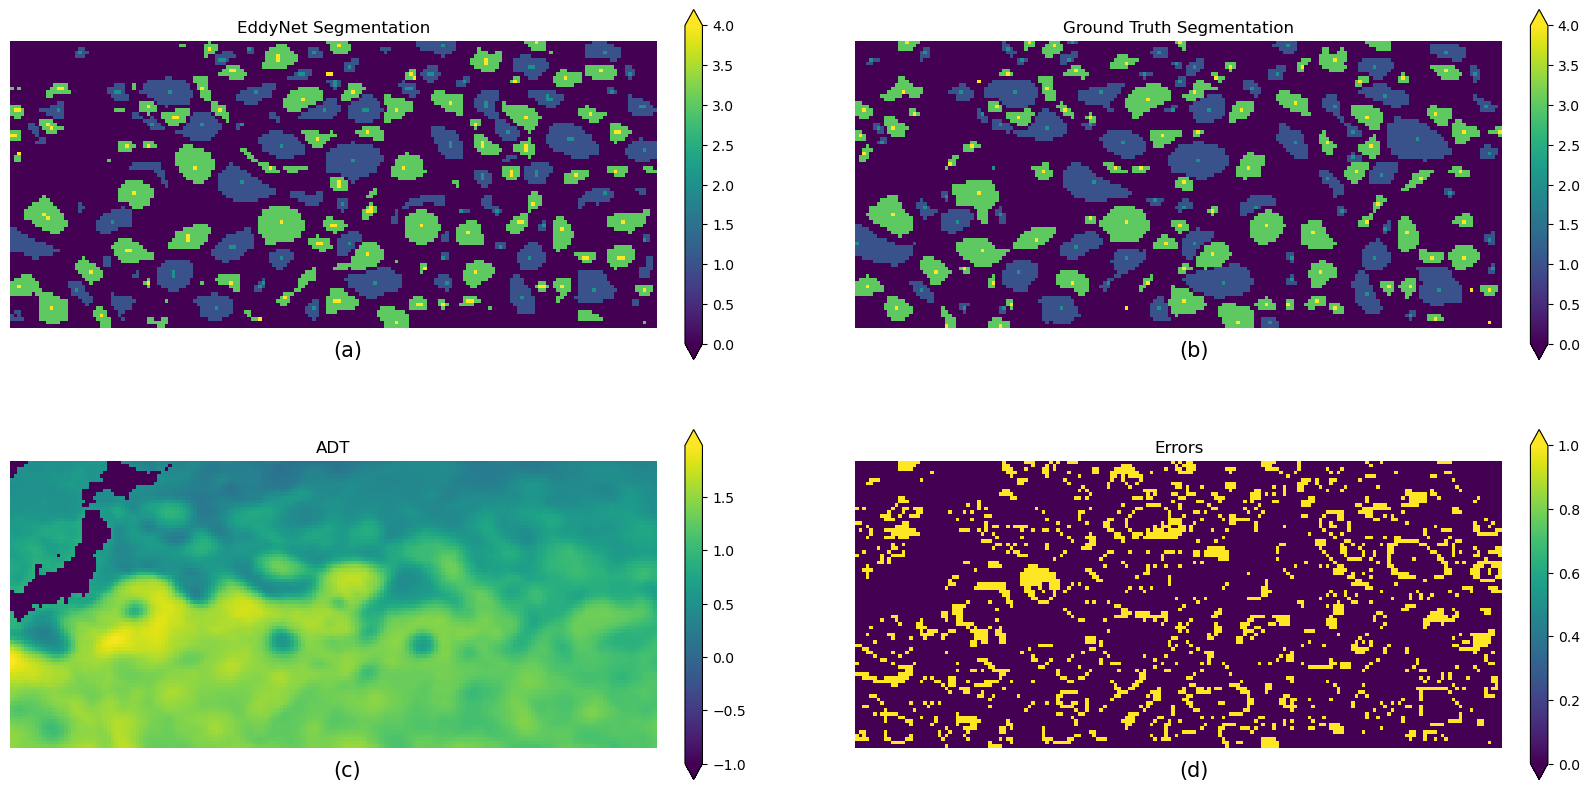

In [30]:
randindex=np.random.randint(0,len(SSH_test))
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))
predictedSEGMimage=predictedSEGMimage[::-1,6:-6]

plt.figure(figsize=(20, 10))

plt.subplot(221)
plt.text(0.5, -0.1, '(a)', transform=plt.subplot(221).transAxes, size=15)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('EddyNet Segmentation');

plt.subplot(222)
plt.text(0.5, -0.1, '(b)', transform=plt.subplot(222).transAxes, size=15)
plt.imshow(Seg_test[randindex,::-1,6:-6,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Ground Truth Segmentation');

plt.subplot(223)
plt.text(0.5, -0.1, '(c)', transform=plt.subplot(223).transAxes, size=15)
plt.imshow(SSH_test[randindex,::-1,6:-6,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ADT');

plt.subplot(224)
plt.text(0.5, -0.1, '(d)', transform=plt.subplot(224).transAxes, size=15)
plt.imshow(np.where(predictedSEGMimage == Seg_test[randindex,::-1,6:-6,0], 0, 1))
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Errors');

Seems working nicely, but there are some false eddy detections that need to be dealt with, working on it..

In [17]:
#### if you wanna use some animations ;) 


#imageList=[]
#for i in range(1200,1400):
#    imageList.append(SSH_train[i,:,:,0])
  

#print('drawing the animation...')
#from matplotlib import animation, rc
#from IPython.display import HTML

#def getImageFromList(x):
#    return imageList[x]

#fig = plt.figure(figsize=(10, 10))
#ims = []
#for i in range(len(imageList)):
#    im = plt.imshow(getImageFromList(i), animated=True, cmap='viridis')
#    ims.append([im])
#plt.axis('off')

#ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=False)
#plt.close()

#HTML(ani.to_jshtml())

## metrics on test dataset

In [18]:
Seg_test_categor = utils.to_categorical(np.reshape(Seg_test[:,:,:,0],(365,80*192)),5)
Seg_test_categor.shape

(365, 15360, 5)

In [19]:
eddynet.evaluate(SSH_test,Seg_test_categor)

12/12 [==============================] - 1s 65ms/step - loss: 0.4369 - categorical_accuracy: 0.8463 - mean_dice_coef: 0.6502 - weighted_mean_dice_coef: 0.5608


[0.43693625926971436,
 0.846285879611969,
 0.6501902937889099,
 0.5607741475105286]

# Data for statistics

In [20]:
predictedSEGM_train = eddynet.predict(np.reshape(SSH_train,(-1,height,width,1)))
predictedSEGMimage_train = np.reshape(predictedSEGM_train.argmax(2),(-1,height,width))
predictedSEGMimage_train = predictedSEGMimage_train[:,::-1,6:-6]
    
predictedSEGM_test = eddynet.predict(np.reshape(SSH_test,(-1,height,width,1)))
predictedSEGMimage_test = np.reshape(predictedSEGM_test.argmax(2),(-1,height,width))
predictedSEGMimage_test = predictedSEGMimage_test[:,::-1,6:-6]

eddy_detected = np.concatenate((predictedSEGMimage_train, predictedSEGMimage_test), axis=0)
np.save('../Data/eddy_detected.npy',eddy_detected.astype(np.int8))

12/12 [==============================] - 1s 47ms/step


In [21]:
eddynet.save('./Models/eddynet.keras')

/Users/jjijack/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
